# MP1: Regression Analysis for Band Gap Prediction

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Step 1: Loading the dataset
dataset_path = "citrination-export-band-gaps.csv"  # Update as needed
data = pd.read_csv(dataset_path)

# Inspecting the dataset
print("Dataset Loaded: ", data.shape)
print("Dataset Columns: ", data.columns)

# Step 2: Handling missing values
data.dropna(inplace=True)
print("Dataset after dropping missing values: ", data.shape)

# Step 2.5: Cleaning the target column (Property Band gap)
def extract_numeric(value):
    """Extract the numeric part of a value with uncertainty or range annotations."""
    try:
        return float(value.split('$')[0])  # Extract the numeric part before '$'
    except:
        return np.nan  # Return NaN if conversion fails

# Applying the cleaning function to the target column
data['Property Band gap'] = data['Property Band gap'].apply(extract_numeric)

# Droping rows where the target could not be converted
data.dropna(subset=['Property Band gap'], inplace=True)

print("Dataset after cleaning target column:", data.shape)


# Step 3: Define features (X) and target (y)
X = data.drop(columns=['Property Band gap'])  # we can update the target column name as necessary
y = data['Property Band gap']

# Identifying and handling non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
print("Non-Numeric Columns:", non_numeric_cols)

# we can drop or encode non-numeric columns
if len(non_numeric_cols) > 0:
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

print("Processed Feature Matrix Shape:", X.shape)

# Step 4: splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size: ", X_train.shape)
print("Testing set size: ", X_test.shape)

# Step 5: training and evaluating regression models
# Initializing models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

from sklearn.preprocessing import StandardScaler

# scaling the target variable
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# finally proceeding with the training and testing steps:))

# Training and evaluating models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "R2": r2
    })

# Converting results to dataframe for better visualization
results_df = pd.DataFrame(results)
print("Model Performance:")
print(results_df)

# Step 6: Saving results to a CSV file
results_df.to_csv("model_performance_band_gaps.csv", index=False)
print("Model performance saved to model_performance_band_gaps.csv")


Dataset Loaded:  (1449, 5)
Dataset Columns:  Index(['formula', 'Property Band gap', 'Property Band gap units',
       'Property Crystallinity', 'Property Color'],
      dtype='object')
Dataset after dropping missing values:  (125, 5)
Dataset after cleaning target column: (125, 5)
Non-Numeric Columns: Index(['formula', 'Property Band gap units', 'Property Crystallinity',
       'Property Color'],
      dtype='object')
Processed Feature Matrix Shape: (125, 92)
Training set size:  (100, 92)
Testing set size:  (25, 92)
Model Performance:
               Model           MAE           MSE            R2
0  Linear Regression  7.149577e+11  2.001813e+24 -1.303710e+24
1      Random Forest  7.036872e-01  1.545932e+00 -6.810913e-03
2  Gradient Boosting  7.201147e-01  1.445315e+00  5.871741e-02
Model performance saved to model_performance_band_gaps.csv


# MP2 - Unsupervised Learning and Leave-One-Group-Out Cross-Validation (LOGO-CV)

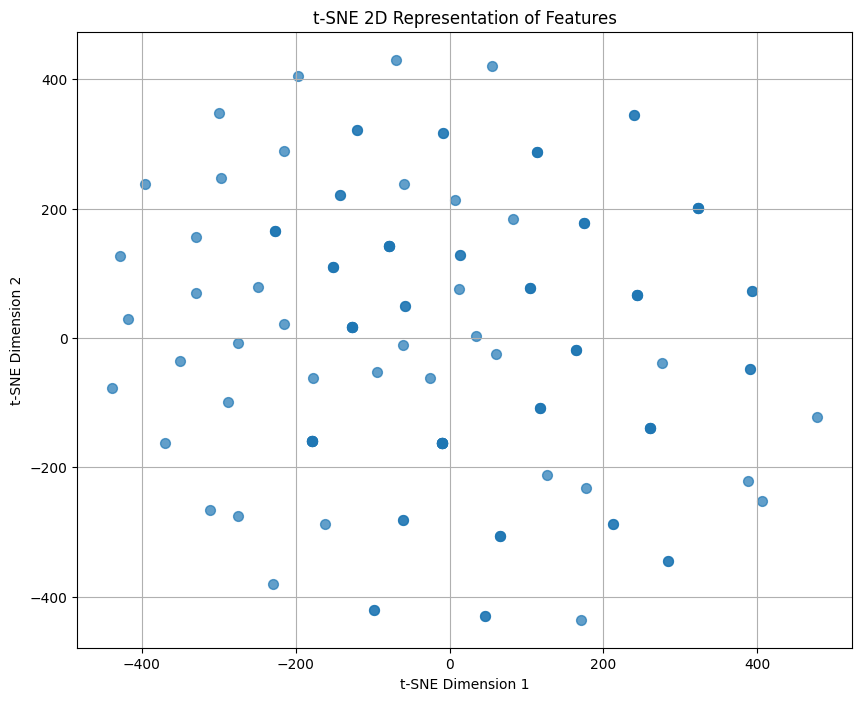

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Step 1: Load the Preprocessed Data
# Assuming `X` is the preprocessed feature matrix from MP1
# If not already scaled, apply scaling again for dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply t-SNE
# Experiment with perplexity and random_state to find the best 2D representation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_scaled)

# Step 3: Visualize t-SNE Result
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7, s=50)
plt.title("t-SNE 2D Representation of Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.savefig("tsne_2d_representation.png")
plt.show()


# Step 1: DBSCAN Clustering
* tried different values for eps (neighborhood distance) and min_samples to optimize the number of clusters and reduce noise points.

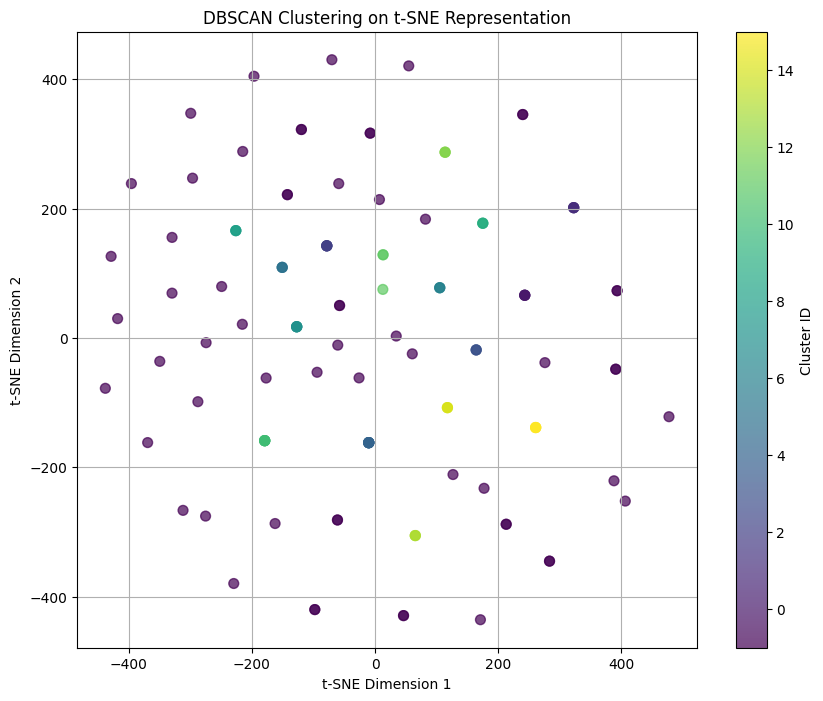

Number of clusters: 16
Number of noise points: 62


In [45]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Step 1: Apply DBSCAN
# Adjust eps (epsilon) and min_samples for optimal clustering
dbscan = DBSCAN(eps=60, min_samples=3)  # Initial parameters
clusters = dbscan.fit_predict(X_2d)

# Step 2: Visualize DBSCAN Clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7, s=50)
plt.title("DBSCAN Clustering on t-SNE Representation")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)

plt.show()

# Step 3: Print Cluster Statistics
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise points
n_noise = list(clusters).count(-1)  # Noise points are labeled as -1

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")


In [48]:
# Reset indices for X_valid (DataFrame) and groups (if they are pandas Series)
X_valid = X_valid.reset_index(drop=True)  # Ensure proper alignment for DataFrame
groups = pd.Series(groups).reset_index(drop=True)  # Convert groups to Series and reset index

# y_valid is already a NumPy array, so no reset_index is needed
y_valid_np = y_valid  # Use as-is

# Convert X_valid to NumPy array for compatibility with LOGO-CV
X_valid_np = X_valid.values  # Feature matrix as a NumPy array

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Models to Evaluate (Reusing Models from MP1)
models = {
    "Ridge Regression": Ridge(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# LOGO-CV Evaluation
results_logo = []
for name, model in models.items():
    mae_list, mse_list, r2_list = [], [], []
    for train_idx, test_idx in logo.split(X_valid_np, y_valid_np, groups=groups):
        model.fit(X_valid_np[train_idx], y_valid_np[train_idx])
        y_pred = model.predict(X_valid_np[test_idx])
        
        mae_list.append(mean_absolute_error(y_valid_np[test_idx], y_pred))
        mse_list.append(mean_squared_error(y_valid_np[test_idx], y_pred))
        r2_list.append(r2_score(y_valid_np[test_idx], y_pred))
    
    results_logo.append({
        "Model": name,
        "MAE": np.mean(mae_list),
        "MSE": np.mean(mse_list),
        "R2": np.mean(r2_list),
    })

# Save and Display Results
results_logo_df = pd.DataFrame(results_logo)
print("LOGO-CV Results:")
print(results_logo_df)
results_logo_df.to_csv("logo_cv_results.csv", index=False)


LOGO-CV Results:
               Model       MAE       MSE           R2
0   Ridge Regression  0.740937  1.281628 -2683.773587
1  Gradient Boosting  0.820184  1.974246 -1521.336701


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Use the same valid dataset
X_random = X_valid_np
y_random = y_valid_np

# Define scoring metrics
scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "R2": make_scorer(r2_score),
}

# Evaluate Models Using Random-CV
results_random = []
for name, model in models.items():
    scores = cross_val_score(model, X_random, y_random, scoring=scoring["MAE"], cv=5)
    mae = -np.mean(scores)  # Convert negative scoring back to positive MAE
    
    scores = cross_val_score(model, X_random, y_random, scoring=scoring["MSE"], cv=5)
    mse = -np.mean(scores)  # Convert negative scoring back to positive MSE
    
    scores = cross_val_score(model, X_random, y_random, scoring=scoring["R2"], cv=5)
    r2 = np.mean(scores)
    
    results_random.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "R2": r2,
    })

# Save and Display Results
results_random_df = pd.DataFrame(results_random)
print("Random-CV Results:")
print(results_random_df)
results_random_df.to_csv("random_cv_results.csv", index=False)


Random-CV Results:
               Model       MAE       MSE        R2
0   Ridge Regression  0.326974  0.307477  0.682838
1  Gradient Boosting  0.226410  0.245286  0.718830


In [51]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Function to perform DBSCAN with varying parameters
def dbscan_parameter_exploration(X_2d, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_2d)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            n_noise = list(clusters).count(-1)
            
            results.append({
                "eps": eps,
                "min_samples": min_samples,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
            })
            
            # Plot clustering result
            plt.figure(figsize=(8, 6))
            plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7, s=50)
            plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})")
            plt.xlabel("t-SNE Dimension 1")
            plt.ylabel("t-SNE Dimension 2")
            plt.colorbar(label="Cluster ID")
            plt.savefig(f"dbscan_eps{eps}_min{min_samples}.png")
            plt.close()
            
    return results

# Define parameter ranges
eps_values = [30, 50, 70]  # Experiment with neighborhood distances
min_samples_values = [3, 5, 7]  # Experiment with minimum points in a cluster

# Perform DBSCAN parameter exploration
dbscan_results = dbscan_parameter_exploration(X_2d, eps_values, min_samples_values)

# Display results
import pandas as pd
dbscan_results_df = pd.DataFrame(dbscan_results)
print("DBSCAN Parameter Exploration Results:")
print(dbscan_results_df)
dbscan_results_df.to_csv("dbscan_parameter_exploration.csv", index=False)


DBSCAN Parameter Exploration Results:
   eps  min_samples  n_clusters  n_noise
0   30            3          15       65
1   30            5           4      101
2   30            7           1      117
3   50            3          15       65
4   50            5           4      101
5   50            7           1      117
6   70            3          19       50
7   70            5           5       96
8   70            7           1      117


In [53]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to perform k-means clustering with different k values
def kmeans_parameter_exploration(X_pca, k_values):
    results = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_pca)
        
        # Save clustering results
        results.append({
            "k": k,
            "inertia": kmeans.inertia_,  # Sum of squared distances to cluster centers
        })
        
        # Plot clustering result
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7, s=50)
        plt.title(f"K-Means Clustering (k={k})")
        plt.xlabel("PCA Dimension 1")
        plt.ylabel("PCA Dimension 2")
        plt.colorbar(label="Cluster ID")
        plt.savefig(f"kmeans_k{k}.png")
        plt.close()
    
    return results

# Define parameter range for k
k_values = [2, 4, 6, 8]  # Experiment with different numbers of clusters

# Perform k-means parameter exploration
kmeans_results = kmeans_parameter_exploration(X_pca, k_values)

# Display results
kmeans_results_df = pd.DataFrame(kmeans_results)
print("K-Means Parameter Exploration Results:")
print(kmeans_results_df)
kmeans_results_df.to_csv("kmeans_parameter_exploration.csv", index=False)


K-Means Parameter Exploration Results:
   k     inertia
0  2  365.024756
1  4   96.758358
2  6   62.737919
3  8   25.149219


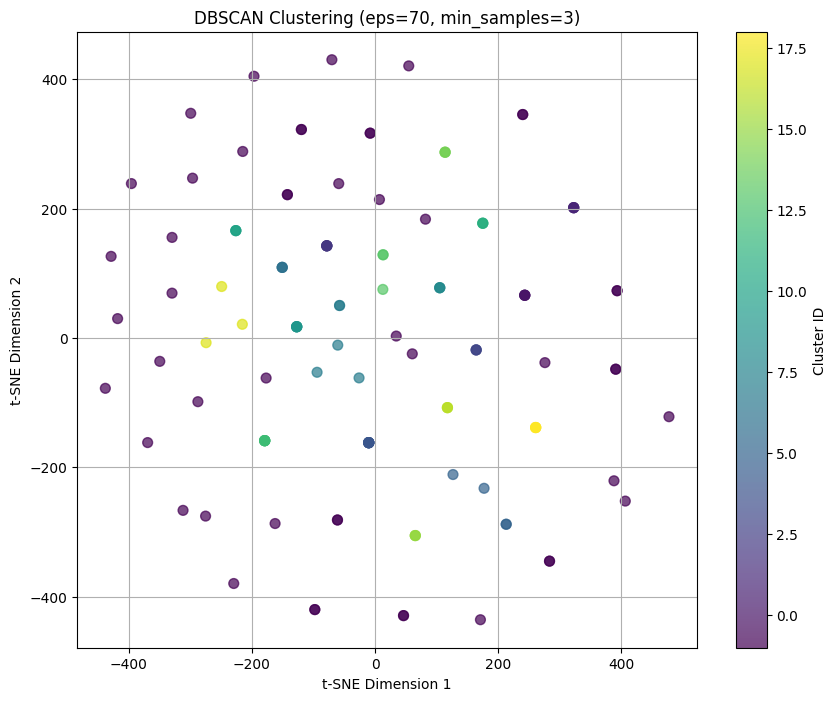

DBSCAN - Number of clusters: 19
DBSCAN - Number of noise points: 50


In [54]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Apply DBSCAN with selected parameters
dbscan = DBSCAN(eps=70, min_samples=3)
dbscan_clusters = dbscan.fit_predict(X_2d)

# Visualize DBSCAN Clustering
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan_clusters, cmap='viridis', alpha=0.7, s=50)
plt.title("DBSCAN Clustering (eps=70, min_samples=3)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.savefig("dbscan_selected_clustering.png")
plt.show()

# Print DBSCAN summary
n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise_dbscan = list(dbscan_clusters).count(-1)
print(f"DBSCAN - Number of clusters: {n_clusters_dbscan}")
print(f"DBSCAN - Number of noise points: {n_noise_dbscan}")


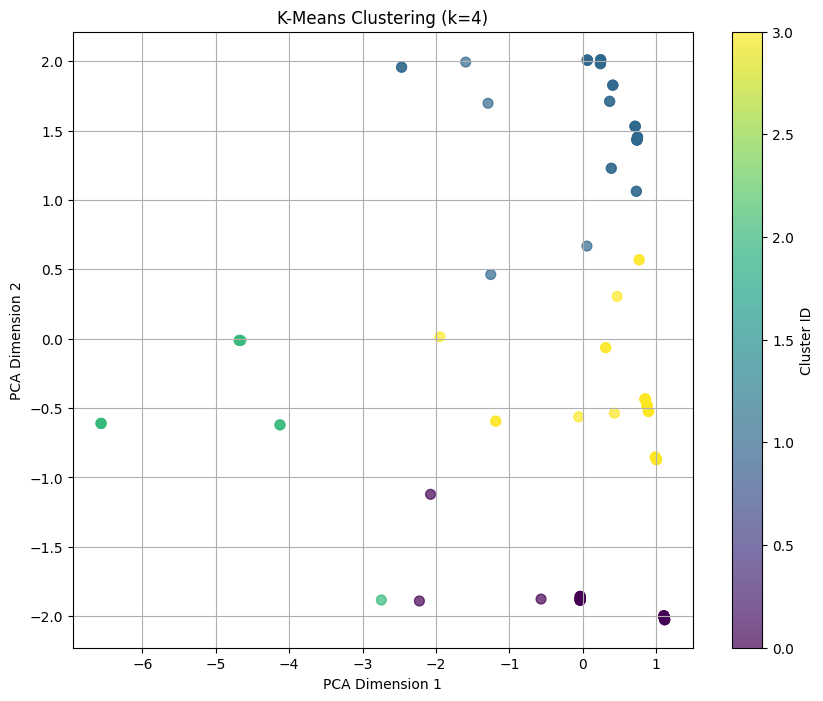

K-Means - Number of clusters: 4
K-Means - Inertia: 96.75835848884302


In [55]:
from sklearn.cluster import KMeans

# Apply K-Means with selected parameters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_pca)  # Use PCA-reduced data

# Visualize K-Means Clustering
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis', alpha=0.7, s=50)
plt.title("K-Means Clustering (k=4)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.savefig("kmeans_selected_clustering.png")
plt.show()

# Print K-Means summary
print(f"K-Means - Number of clusters: {4}")
print(f"K-Means - Inertia: {kmeans.inertia_}")


In [59]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# DBSCAN Clusters
valid_indices_dbscan = dbscan_clusters != -1  # Exclude noise points (-1)
X_dbscan = X[valid_indices_dbscan]
y_dbscan = y[valid_indices_dbscan]
groups_dbscan = dbscan_clusters[valid_indices_dbscan]

# K-Means Clusters
X_kmeans = X
y_kmeans = y
groups_kmeans = kmeans_clusters  # Use k-means cluster labels

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Models to Evaluate (Reusing MP1 Models)
models = {
    "Ridge Regression": Ridge(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# LOGO-CV Function
def logo_cv_evaluation(X, y, groups, models):
    results = []
    for name, model in models.items():
        mae_list, mse_list, r2_list = [], [], []
        for train_idx, test_idx in logo.split(X, y, groups=groups):
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            
            mae_list.append(mean_absolute_error(y[test_idx], y_pred))
            mse_list.append(mean_squared_error(y[test_idx], y_pred))
            r2_list.append(r2_score(y[test_idx], y_pred))
        
        results.append({
            "Model": name,
            "MAE": np.mean(mae_list),
            "MSE": np.mean(mse_list),
            "R2": np.mean(r2_list),
        })
    return results
# Filter valid points (exclude noise)
X_dbscan = X[valid_indices_dbscan].reset_index(drop=True)  # Reset index for DataFrame
y_dbscan = y[valid_indices_dbscan]  # No reset_index needed for NumPy array
groups_dbscan = pd.Series(groups_dbscan).reset_index(drop=True)  # Convert groups to a Series

# Convert to NumPy arrays for LOGO-CV compatibility
X_dbscan_np = X_dbscan.values  # Convert DataFrame to NumPy array
y_dbscan_np = y_dbscan  # Already a NumPy array
groups_dbscan_np = groups_dbscan.values  # Convert Series to NumPy array

# Evaluate DBSCAN Clusters with LOGO-CV
print("Evaluating DBSCAN Clusters with LOGO-CV...")
results_dbscan = logo_cv_evaluation(X_dbscan_np, y_dbscan_np, groups_dbscan_np, models)
results_dbscan_df = pd.DataFrame(results_dbscan)
print("DBSCAN LOGO-CV Results:")
print(results_dbscan_df)

results_dbscan_df.to_csv("logo_cv_results_dbscan.csv", index=False)



# Evaluate K-Means Clusters with LOGO-CV
# Reset indices for K-Means data
X_kmeans = X.reset_index(drop=True)
y_kmeans = pd.Series(y).reset_index(drop=True)  # Convert to Series for alignment
groups_kmeans = pd.Series(groups_kmeans).reset_index(drop=True)  # Ensure alignment

# Convert to NumPy arrays
X_kmeans_np = X_kmeans.values  # Feature matrix as NumPy array
y_kmeans_np = y_kmeans.values  # Target variable as NumPy array
groups_kmeans_np = groups_kmeans.values  # Groups as NumPy array

# Evaluate K-Means Clusters with LOGO-CV
print("Evaluating K-Means Clusters with LOGO-CV...")
results_kmeans = logo_cv_evaluation(X_kmeans_np, y_kmeans_np, groups_kmeans_np, models)
results_kmeans_df = pd.DataFrame(results_kmeans)
print("K-Means LOGO-CV Results:")
print(results_kmeans_df)
results_kmeans_df.to_csv("logo_cv_results_kmeans.csv", index=False)



Evaluating DBSCAN Clusters with LOGO-CV...
DBSCAN LOGO-CV Results:
               Model       MAE       MSE           R2
0   Ridge Regression  0.730872  1.217978 -2372.533398
1  Gradient Boosting  0.755793  1.614165 -1258.094708
Evaluating K-Means Clusters with LOGO-CV...
K-Means LOGO-CV Results:
               Model       MAE       MSE        R2
0   Ridge Regression  0.759554  1.028058 -0.024318
1  Gradient Boosting  0.762255  1.035278 -0.029531
